In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

df=pd.read_csv('bacterials.csv')
df

,Length,Diameter,Gram stain,Shape,Formation,Lab
0,0.954362,1.047672,Positive,Spherical-shaped,Groups,1
1,0.778485,0.561691,Positive,Spherical-shaped,Pairs,0
2,1.107574,0.930471,Positive,Spherical-shaped,Groups,0
3,0.658759,0.482882,Positive,Spherical-shaped,Pairs,0
4,0.982178,0.981590,Positive,Spherical-shaped,Groups,0
...,...,...,...,...,...,...
795,1.878150,0.240841,Negative,Rod-shaped,Singles,0
796,0.981411,0.905475,Positive,Spherical-shaped,Groups,0
797,1.011309,1.089037,Positive,Spherical-shaped,Groups,0
798,0.728574,0.416559,Positive,Spherical-shaped,Pairs,1


## 1. Preprocess Data

Melakukan pengecekan terhadap data kosong. Hasil yang diperoleh yaitu tidak ada data yang kosong sehingga tahapan berikutnya dapat dilakukan. 

In [7]:
print(df.columns[df.isna().any()].tolist())
print(df.isna().sum())

[]
Length        0
Diameter      0
Gram stain    0
Shape         0
Formation     0
Lab           0
dtype: int64


Mengolah data kategorikal menjadi numerik dengan one hot encoding.

In [8]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
label_encoder = LabelEncoder()
for i in range(2,5):
  df.iloc[:, i] = label_encoder.fit_transform(df.iloc[:, i])
df

<ipython-input-8-1a13c83e66eb>:4: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.iloc[:, i] = label_encoder.fit_transform(df.iloc[:, i])
<ipython-input-8-1a13c83e66eb>:4: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.iloc[:, i] = label_encoder.fit_transform(df.iloc[:, i])
<ipython-input-8-1a13c83e66eb>:4: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are n

,Length,Diameter,Gram stain,Shape,Formation,Lab
0,0.954362,1.047672,1,1,0,1
1,0.778485,0.561691,1,1,1,0
2,1.107574,0.930471,1,1,0,0
3,0.658759,0.482882,1,1,1,0
4,0.982178,0.981590,1,1,0,0
...,...,...,...,...,...,...
795,1.878150,0.240841,0,0,2,0
796,0.981411,0.905475,1,1,0,0
797,1.011309,1.089037,1,1,0,0
798,0.728574,0.416559,1,1,1,1


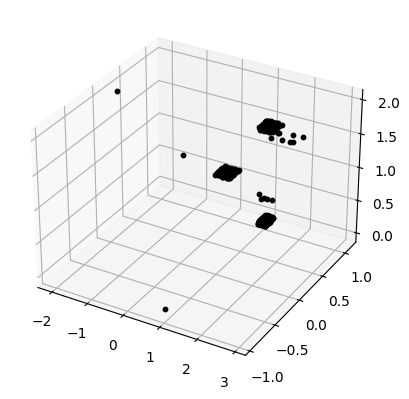

In [12]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

for i in range(500):
  ax.scatter(df['Length'][i],df['Diameter'][i],df['Formation'][i], marker='o',c='k',s=10)

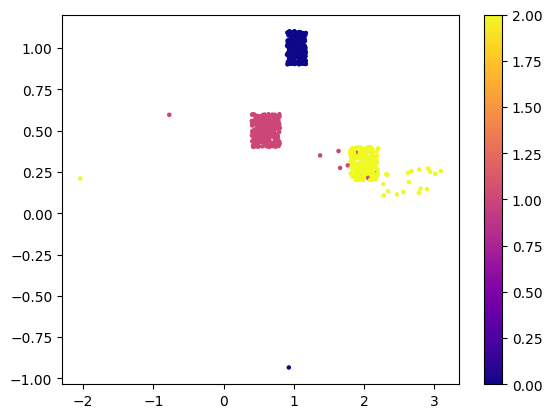

In [13]:
f, ax = plt.subplots()

points = ax.scatter(df['Length'], df['Diameter'], c=df['Formation'], s=5, cmap="plasma")
f.colorbar(points)
plt.show()

Dapat dilihat bahwa data membentuk tiga kluster dan terdapat sedikit outlier.Unutuk melakukan klusterisasi, data tidak perlu dilakukan preprocess karena dalam algoritma DBSCAN outlier tidak berpengaruh.

## 2. Implement DBSCAN

Berdasarkan nilai fitur numerik yang tersedia, nilai 'eps' yang cocok digunakan berkisar pada rentang [0.125, 1], sedangkan berdasarkan jumlah data 'min_samples' yang cocok digunakan berkisar pada rentang [125, 250].

In [14]:
from sklearn.cluster import DBSCAN
from itertools import product
from sklearn.metrics import silhouette_score


X_numerics = df[['Length', 'Diameter']]

eps_values = np.arange(0.125,1.125,0.125) # eps values to be investigated
min_samples = np.arange(125,250,25) # min_samples values to be investigated
DBSCAN_params = list(product(eps_values, min_samples))

no_of_clusters = []
sil_score = []

for p in DBSCAN_params:
    DBS_clustering = DBSCAN(eps=p[0], min_samples=p[1]).fit(X_numerics)
    no_of_clusters.append(len(np.unique(DBS_clustering.labels_)))
    sil_score.append(silhouette_score(X_numerics, DBS_clustering.labels_))

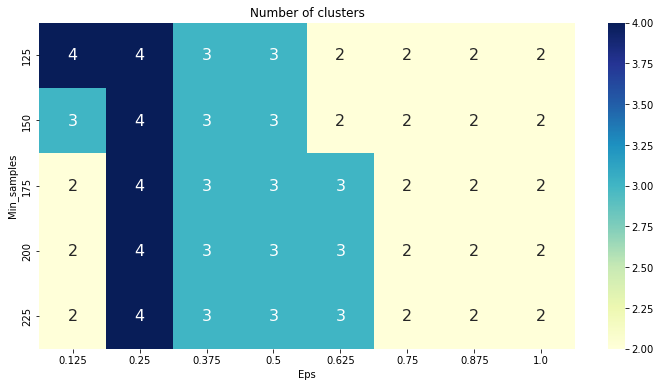

In [ ]:
tmp = pd.DataFrame.from_records(DBSCAN_params, columns =['Eps', 'Min_samples'])   
tmp['No_of_clusters'] = no_of_clusters

pivot_1 = pd.pivot_table(tmp, values='No_of_clusters', index='Min_samples', columns='Eps')

fig, ax = plt.subplots(figsize=(12,6))
sns.heatmap(pivot_1, annot=True,annot_kws={"size": 16}, cmap="YlGnBu", ax=ax)
ax.set_title('Number of clusters')
plt.show()

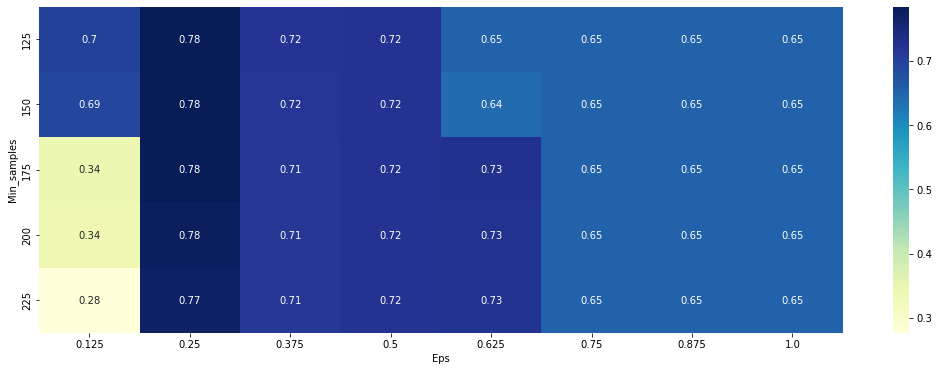

In [ ]:
tmp = pd.DataFrame.from_records(DBSCAN_params, columns =['Eps', 'Min_samples'])   
tmp['Sil_score'] = sil_score

pivot_1 = pd.pivot_table(tmp, values='Sil_score', index='Min_samples', columns='Eps')

fig, ax = plt.subplots(figsize=(18,6))
sns.heatmap(pivot_1, annot=True, annot_kws={"size": 10}, cmap="YlGnBu", ax=ax)
plt.show()

## 3. The Best Parameter for DBSCAN

Berdasarkan dua plot tersebut, jumlah kluster terbaik adalah 3 kluster dengan 1 pencilan (4) dengan silhouette score 0.78. Nilai ini tercapai saat nilai eps 0.25 dan min_samples 125-200.  

In [15]:
DBS_clustering = DBSCAN(eps=0.25, min_samples=125).fit(X_numerics)

DBSCAN_clustered = X_numerics.copy()
DBSCAN_clustered.loc[:,'Cluster'] = DBS_clustering.labels_ # append labels to points
DBSCAN_clust_sizes = DBSCAN_clustered.groupby('Cluster').size().to_frame()
DBSCAN_clust_sizes.columns = ["DBSCAN_size"]
DBSCAN_clust_sizes

,DBSCAN_size
Cluster,
-1,17
0,279
1,269
2,235


## 4. Plot hasil klusterisasi

<Axes: xlabel='Length', ylabel='Diameter'>

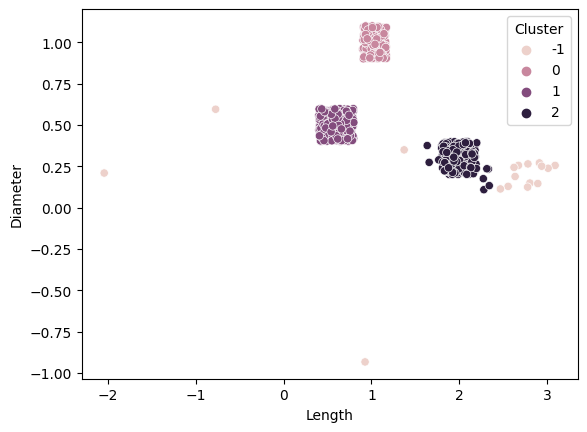

In [16]:
sns.scatterplot(x="Length", y="Diameter", hue="Cluster", data=DBSCAN_clustered)

Dari hasil plot data terbagi menjadi tiga kluster dengan masing-masing memiliki 'formation' berbeda. Jadi, klusterisasi menggunakan DBSCAN sudah cukup berhasil karena hasil klusterisasi memiliki makna yang cukup dekat dengan salah satu fitur sebenarnya.